# Numerical PDE solution using Physics-informed neural networks

In [1]:
import torch
import numpy as np
from heat_612 import heat_nn


np.random.seed(238)
torch.manual_seed(301)

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable

# 1D Heat equation

In [ ]:
### PDE parameters

# dimension
dim=1

# diffusion coefficient
kappa = 0.1

# initial condition
u_0 = lambda x: torch.sin(torch.pi * x) + torch.sin(4 * torch.pi * x)

# right hand side of the equation
rhs = lambda x, t: torch.sin(torch.pi * x)

# analytic solution
u_analytic = lambda x, t: (1 - 1 / (0.1 * torch.pi**2)) * torch.sin(torch.pi * x) * torch.exp(-torch.pi**2 * 0.1 * t
                    ) + torch.sin(4 * torch.pi * x) * torch.exp(- 16 * torch.pi**2 * 0.1 * t
                    ) + 1 / (0.1 * torch.pi**2) * torch.sin(torch.pi * x)

[tensor([[0.0000],
        [0.0101],
        [0.0202],
        ...,
        [0.9798],
        [0.9899],
        [1.0000]])]
1
<class 'list'>
tensor([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]])
10000
<class 'torch.Tensor'>
Epoch 74, Loss: 18.417486, MSE: 0.139645
Epoch 0, Loss: 1.924123, MSE: 0.002441


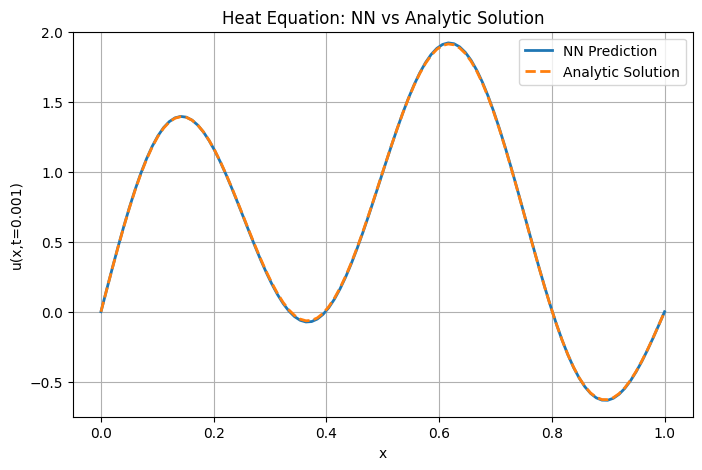

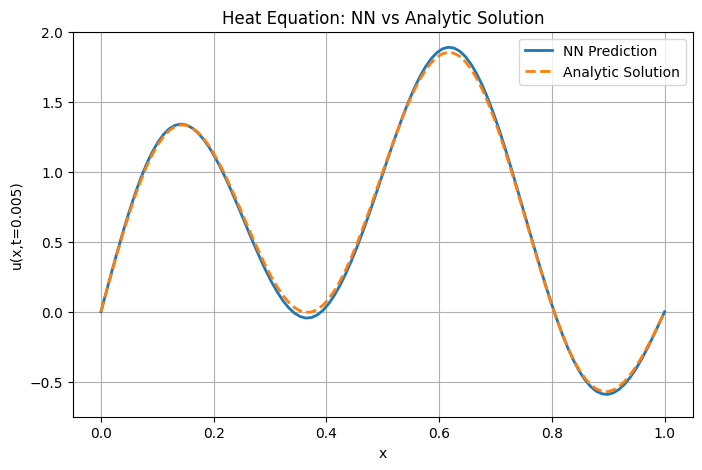

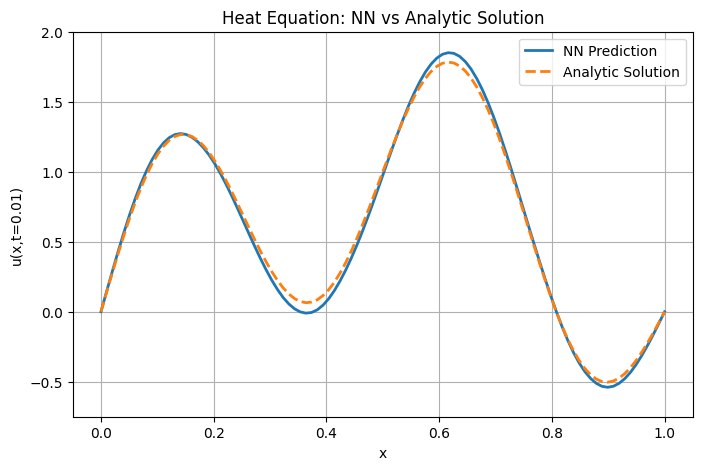

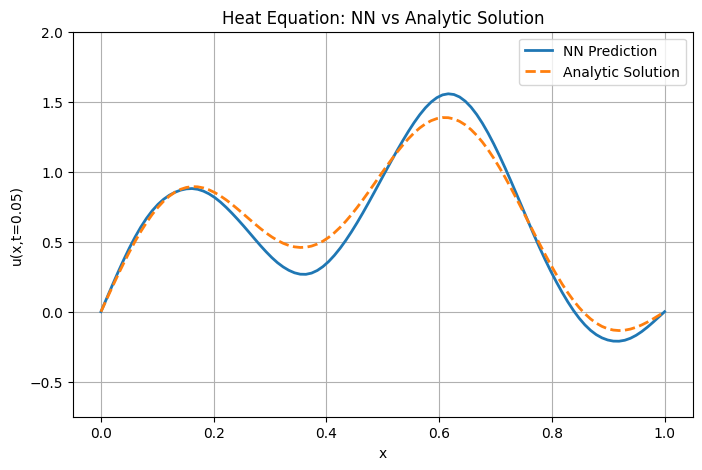

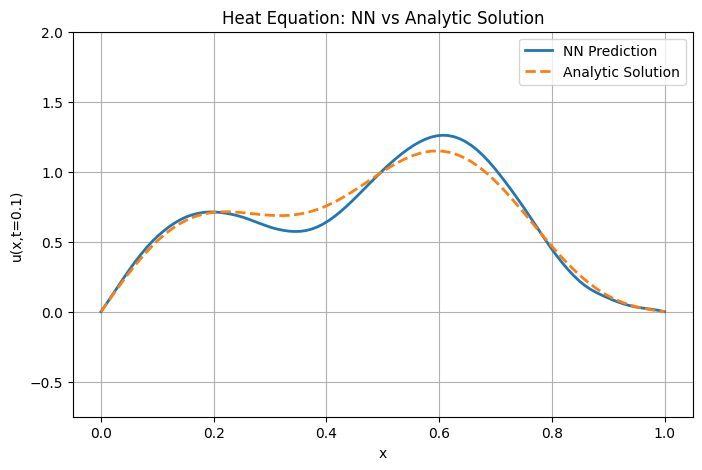

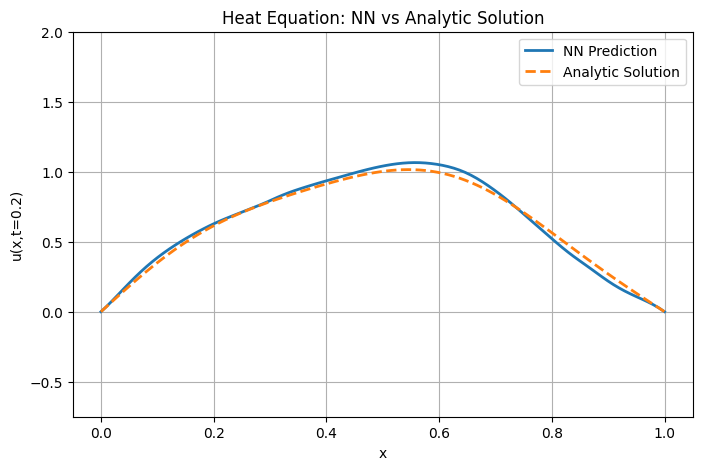

L^2 error:         0.049407925
L_^{infty}_error:  0.17466652


In [ ]:
### Construct the neural network and train it

layers = [32, 64, 128, 128, 1]
#in this example: the output layer uses identity as activation func and all the hidden layers use tanh
activations = [torch.tanh]*(len(layers)-1) + [None]

pde_nn = heat_nn(layers, activations, dim, u_0, kappa, rhs)
pde_nn.set_analytic_solution(u_analytic)
N_colloc = 100
pde_nn.set_data(N_colloc)

# gives relatively good results (compared to other parameters, still bad though)
pde_nn.train(lr=1e-2, weight_decay=0.0, epochs = 75, opt_time_scale =True, print_epochs=50)
# LBFGS needs approximately 100 epochs, 30 iterations for kappa = 1
# if kappa = 0.1, better choose more iterations, less epochs
pde_nn.train_lbfgs(lr=1, opt_time_scale = True, epochs=1, max_iter=100)

In [ ]:
### Plot results

for t in [0.001, 0.005, 0.01, 0.05, 0.1, 0.2]:
    x_test = torch.linspace(0,1,100).view(-1,1)
    t_test = torch.tensor([[t]]*100)  # t=0.5
    u_pred = pde_nn.trial_solution(x_test, t_test).detach().numpy()

    # compare results with analytic solution

    x_np = x_test.numpy().flatten()  # convert to 1D array for plotting
    t_val = t
    u_analytic_val = pde_nn.u_analytic(x_test, t_test)

    # Plot neural network approximation and analytic solution
    plt.figure(figsize=(8,5))
    plt.plot(x_np, u_pred, label='NN Prediction', linewidth=2)
    plt.plot(x_np, u_analytic_val, '--', label='Analytic Solution', linewidth=2)
    plt.xlabel('x')
    plt.ylabel(f'u(x,t={t})')
    plt.ylim(-0.75, 2.0)
    plt.title('Heat Equation: NN vs Analytic Solution')
    plt.legend()
    plt.grid(True)
    plt.show()

### error measured in L^2 and L^{\infty} norm
L_2_err = pde_nn.L_2_error()
L_infty_err = pde_nn.L_infty_error()
print("L^2 error:        ", L_2_err)
print("L_^{infty}_error: ", L_infty_err)

# MSE
print(pde_nn.mse())
print(pde_nn.mse(x_test, t_test))

# 2D Problem

In [3]:
"""
2D Heat equation
"""

u_0 = lambda x, y: torch.sin(torch.pi * x) * torch.sin(torch.pi * y) + torch.sin(
        2 * torch.pi * x) * torch.sin(4 * torch.pi * y)

u_analytic = lambda x, y,t: torch.sin(torch.pi * x) * torch.sin(torch.pi * y) * torch.exp(
    -2 * kappa * torch.pi**2 * t) + torch.sin(2 * torch.pi * x) * torch.sin(4 * torch.pi * y 
    ) * torch.exp(-20 * kappa * torch.pi**2 * t)

dim=2
kappa = 0.1
rhs = lambda x, y, t: 0

Epoch 0, Loss: 35.947258, MSE: 0.087890
Epoch 50, Loss: 31.782948, MSE: 0.082705
Epoch 100, Loss: 25.681067, MSE: 0.105615
Epoch 150, Loss: 18.144739, MSE: 0.060381
Epoch 200, Loss: 8.863140, MSE: 0.027011
Epoch 250, Loss: 5.364208, MSE: 0.011822
Epoch 300, Loss: 3.564388, MSE: 0.006305
Epoch 350, Loss: 2.867470, MSE: 0.005121
Epoch 399, Loss: 2.195183, MSE: 0.003094
Epoch 0, Loss: 2.152022, MSE: 0.003113
Epoch 1, Loss: 2.097773, MSE: 0.002976
Epoch 2, Loss: 1.952619, MSE: 0.002728
Epoch 3, Loss: 1.806613, MSE: 0.002557
Epoch 4, Loss: 1.646462, MSE: 0.002086
Epoch 5, Loss: 1.475346, MSE: 0.001666
Epoch 6, Loss: 1.357857, MSE: 0.001668
Epoch 7, Loss: 1.243503, MSE: 0.001431
Epoch 8, Loss: 1.158920, MSE: 0.001407
Epoch 9, Loss: 1.056147, MSE: 0.001098
Epoch 10, Loss: 0.966198, MSE: 0.000965
Epoch 11, Loss: 0.891254, MSE: 0.000815
Epoch 12, Loss: 0.833116, MSE: 0.000724
Epoch 13, Loss: 0.768003, MSE: 0.000620
Epoch 14, Loss: 0.724565, MSE: 0.000586
Epoch 15, Loss: 0.676727, MSE: 0.000525


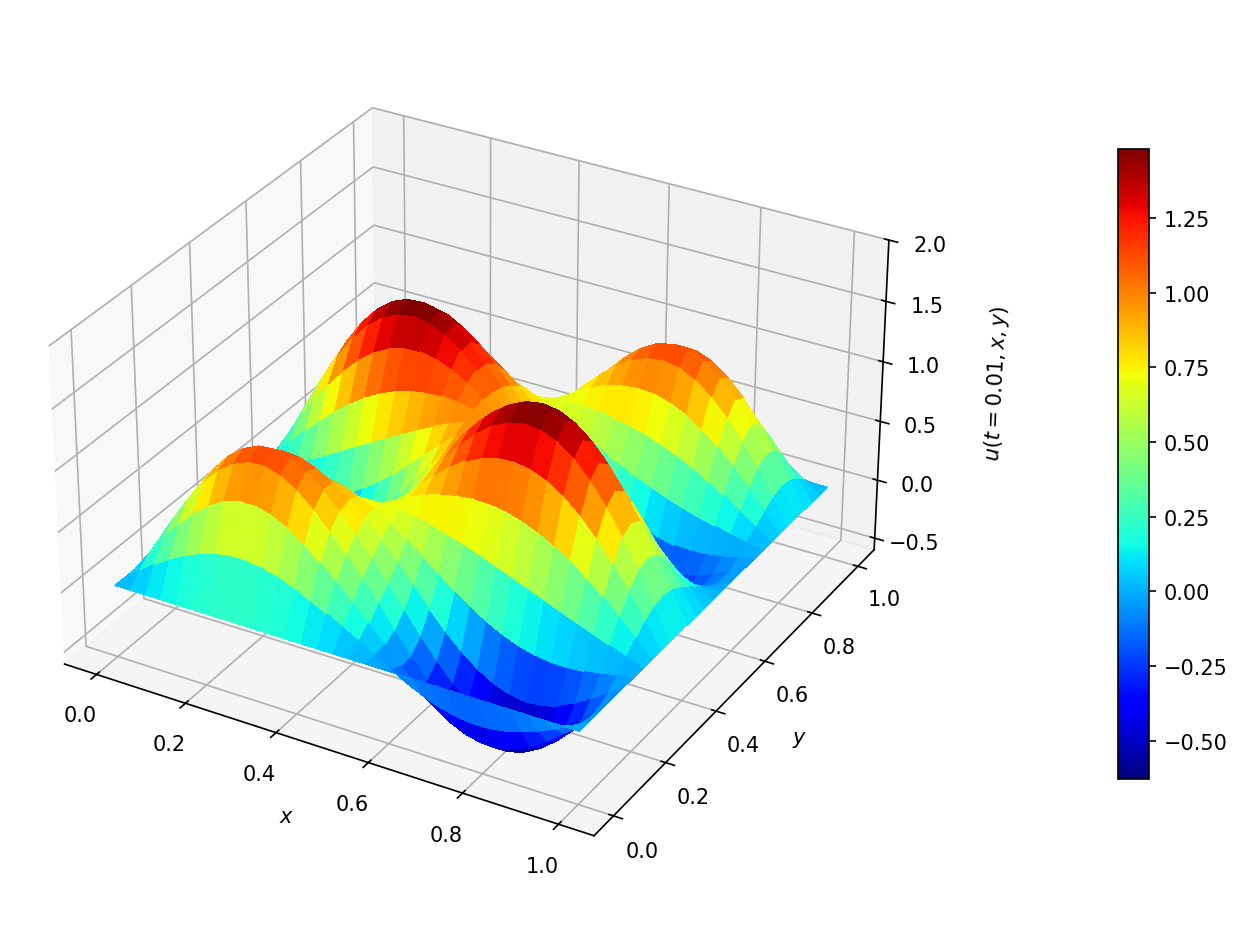

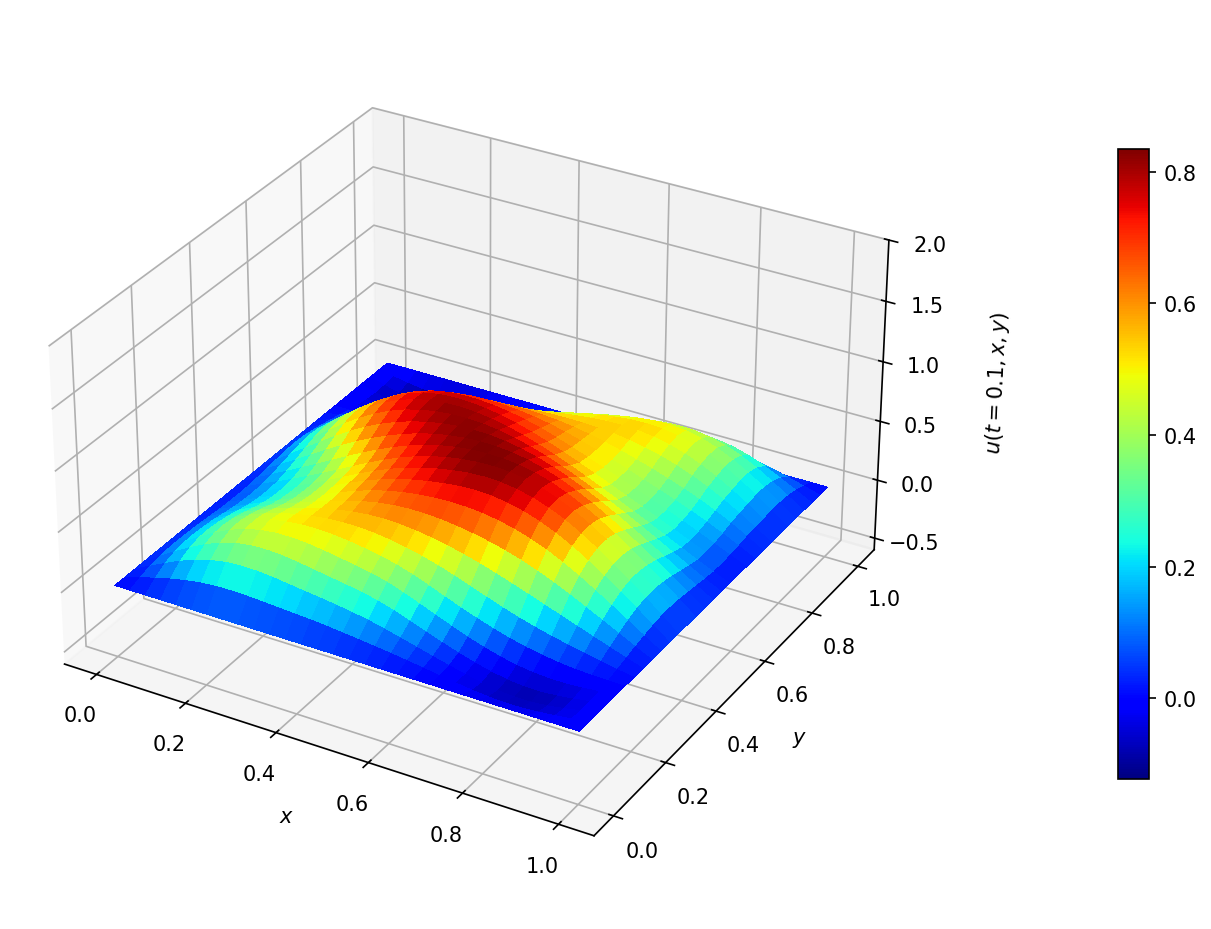

L^2 error:         0.019623516
L_^{infty}_error:  0.16592866


In [ ]:
layers = [32, 64, 128, 128, 1]
activations = [torch.tanh]*(len(layers)-1) + [None]

pde_nn = heat_nn(layers, activations, dim, u_0, kappa, rhs)
pde_nn.set_analytic_solution(u_analytic)
N_colloc = 30
pde_nn.set_data(N_colloc)

pde_nn.train(lr=1e-2, weight_decay=0.0, epochs = 400, opt_time_scale =True, print_epochs=50)
pde_nn.train_lbfgs(lr=1, opt_time_scale = True, epochs=20, max_iter=10)


x_test = torch.linspace(0,1,100).view(-1,1)
y_test = torch.linspace(0,1,100).view(-1,1)
t_test = torch.tensor([[0.001]]*100)  # t=0.001
u_pred = pde_nn.trial_solution(x_test, y_test, t_test).detach().numpy()

In [ ]:
### 3D plot of the solution obtained by our neural network

for t in [0.01, 0.1]:
    # 2D grid
    x = np.linspace(0, 1, N_colloc)
    y = np.linspace(0, 1, N_colloc)
    X, Y = np.meshgrid(x, y)

    # convert grid to NN input (400x1)
    x_test = torch.tensor(X.reshape(-1, 1), dtype=torch.float32)
    y_test = torch.tensor(Y.reshape(-1, 1), dtype=torch.float32)

    t_test = torch.tensor([[t]] * (N_colloc**2), dtype=torch.float32)

    # prediction: shape (400,1)
    u_pred = pde_nn.trial_solution(x_test, y_test, t_test).detach().numpy()

    # reshape to (20,20)
    u_pred = u_pred.reshape(N_colloc, N_colloc)

    # surface plot
    fig = plt.figure(figsize=(9, 6), dpi=150)
    ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], projection="3d")
    surf = ax.plot_surface(X, Y, u_pred, rstride=1, cstride=1, cmap=cm.jet,
                    linewidth=0, antialiased=False)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_zlabel(r'$u(t={}, x, y)$'.format(t), labelpad=12)
    ax.set_zlim(-0.6, 2.0)
    ax.set_position([0, 0, 1, 1])
    ax.set_box_aspect((1, 1, 0.6))

    mappable = surf
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.7, pad=0.15)

    # plt.colorbar()
    fig.canvas.draw()
    plt.savefig("surface.png", bbox_inches="tight", dpi=150)
    plt.show()

### error measured in L^2 and L^{\infty} norm
L_2_err = pde_nn.L_2_error()
L_infty_err = pde_nn.L_infty_error()
print("L^2 error:        ", L_2_err)
print("L_^{infty}_error: ", L_infty_err)

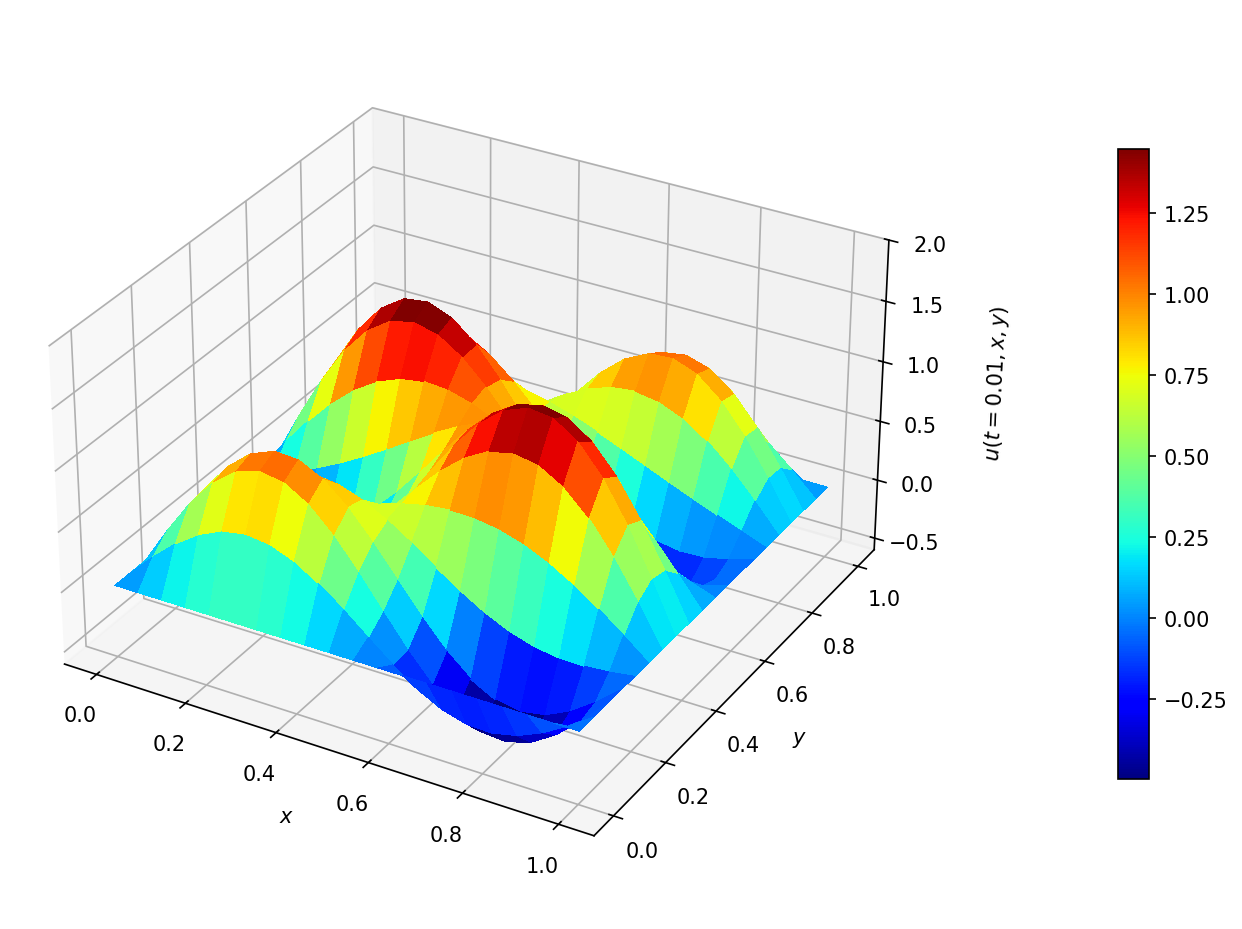

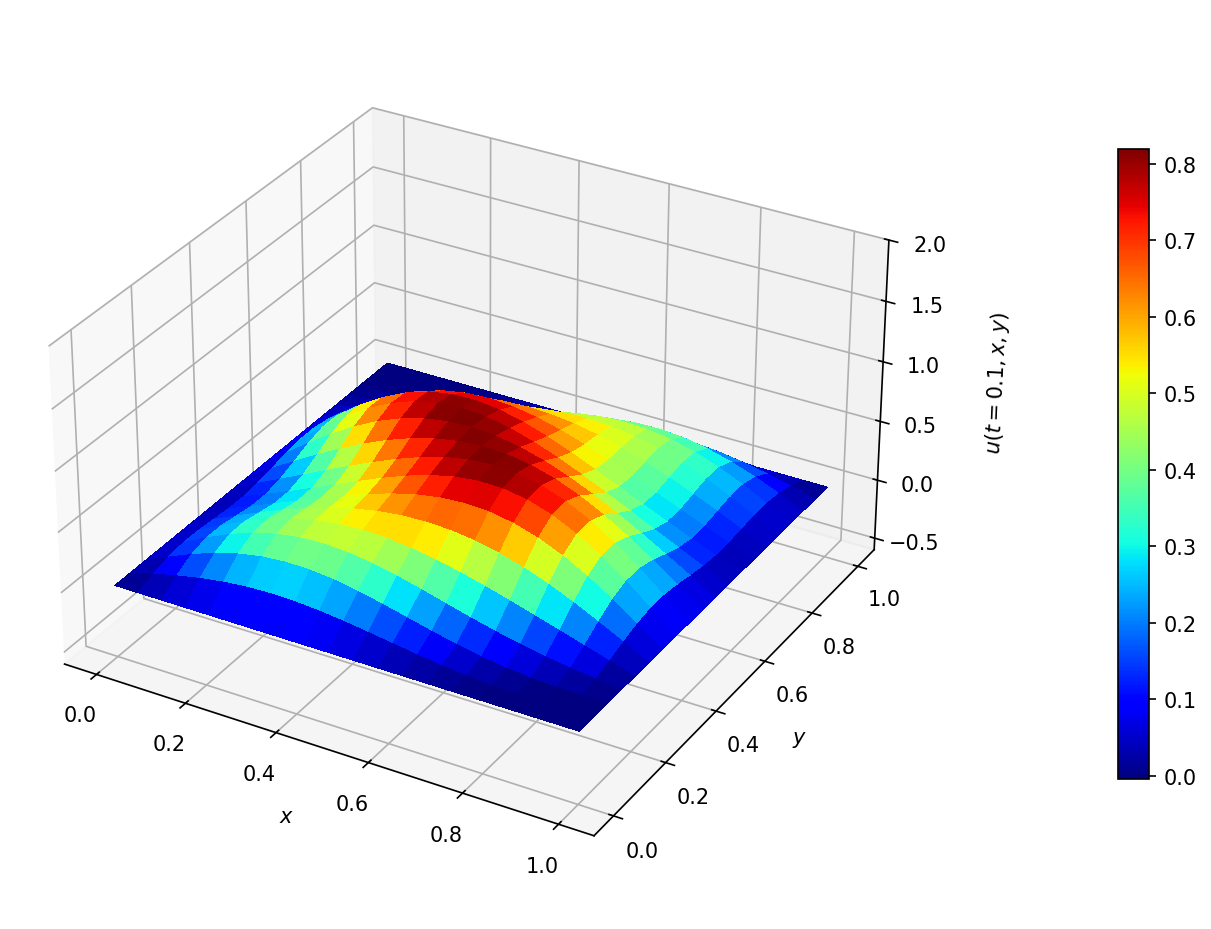

In [ ]:
### 3d Plot of the analytic solution for comparison

for t in [0.01, 0.1]:
    # 2D grid
    x = np.linspace(0, 1, N_colloc)
    y = np.linspace(0, 1, N_colloc)
    X, Y = np.meshgrid(x, y)
    
    # convert grid to NN input (400x1)
    x_test = torch.tensor(X.reshape(-1, 1), dtype=torch.float32)
    y_test = torch.tensor(Y.reshape(-1, 1), dtype=torch.float32)

    t_test = torch.tensor([[t]] * (N_colloc*2), dtype=torch.float32)

    # prediction: shape (N_colloc ** 2,1)
    Z = u_analytic(x_test, y_test, t_test).detach().numpy()
    # reshape to (N_colloc, N_colloc)
    Z = Z.reshape(N_colloc, N_colloc)

    # surface plot
    fig = plt.figure(figsize=(9, 6), dpi=150)
    ax = fig.add_axes([0.0, 0.0, 1.0, 1.0], projection="3d")
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.jet,
                    linewidth=0, antialiased=False)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    ax.set_zlabel(r'$u(t={}, x, y)$'.format(t), labelpad=12)
    ax.set_zlim(-0.6, 2.0)
    ax.set_position([0, 0, 1, 1])
    ax.set_box_aspect((1, 1, 0.6))

    mappable = surf
    cbar = fig.colorbar(mappable, ax=ax, shrink=0.7, pad=0.15)

    # plt.colorbar()
    fig.canvas.draw()
    plt.savefig("surface.png", bbox_inches="tight", dpi=150)
    plt.show()

In [13]:
print(pde_nn.mse())
print(pde_nn.mse(x_test, y_test, t_test))


0.1442077
0.007178256
